In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, concatenate, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
class TimeSeriesSequencer:
    def __init__(self, file_path, date_column, target_column, sequence_length=12):
        """
        Initialisiert die Klasse TimeSeriesSequencer.

        :param file_path: Pfad zur CSV-Datei mit den Daten
        :param date_column: Spaltenname für das Datum
        :param target_column: Spaltenname für die Zielvariable
        :param sequence_length: Länge der Sequenzen
        """
        self.file_path = file_path
        self.date_column = date_column
        self.target_column = target_column
        self.sequence_length = sequence_length
        self.data = None
        self.label_encoders = {}
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        
    def load_data(self):
        """
        Lädt die Daten aus der CSV-Datei und erstellt zusätzliche Features basierend auf dem Datum.
        """
        # Laden der CSV-Datei
        self.data = pd.read_csv(self.file_path)
        # Konvertieren der Datumsspalte in das Datetime-Format
        self.data[self.date_column] = pd.to_datetime(self.data[self.date_column])
        # Erstellen von Jahr- und Monatsspalten
        self.data['Jahr'] = self.data[self.date_column].dt.year
        self.data['Monat'] = self.data[self.date_column].dt.month
        # Erstellen zyklischer Eigenschaften für den Monat
        self.data['Monat_sin'] = np.sin(2 * np.pi * self.data['Monat'] / 12)
        self.data['Monat_cos'] = np.cos(2 * np.pi * self.data['Monat'] / 12)
        
        
    def encode_categorical_features(self, categorical_features):
        """
        Kodiert kategoriale Merkmale mittels Label-Encoding.

        :param categorical_features: Liste der kategorialen Merkmale
        """
        for feature in categorical_features:
            # Initialisieren des LabelEncoders
            le = LabelEncoder()
            # Anpassen und Transformieren der Daten
            self.data[f'{feature}_encoded'] = le.fit_transform(self.data[feature])
            # Speichern des LabelEncoders
            self.label_encoders[feature] = le

    def normalize_features(self, continuous_features):
        """
        Normalisiert kontinuierliche Merkmale.

        :param continuous_features: Liste der kontinuierlichen Merkmale
        """
        # Normalisieren der kontinuierlichen Merkmale außer "Jahr"
        other_cont_features = [feat for feat in continuous_features if feat != 'Jahr']
        self.data[other_cont_features] = self.scaler_X.fit_transform(self.data[other_cont_features])
        # Normalisieren der "Jahr"-Spalte separat
        #self.data[['Jahr']] = MinMaxScaler().fit_transform(self.data[['Jahr']])

    def normalize_target(self):
        """
        Normalisiert die Zielvariable.
        """
        self.data[self.target_column] = self.scaler_y.fit_transform(self.data[[self.target_column]])
        
    def create_sequences(self, continuous_features, encoded_features):
        """
        Erstellt Sequenzen für das Training des Modells.

        :param continuous_features: Liste der kontinuierlichen Merkmale
        :param encoded_features: Liste der kodierten Merkmale
        :return: Sequenzen für die kontinuierlichen Merkmale, kodierten Merkmale, Zielvariablen, Startdaten und Merkmalwerte
        """
        X_cont_seq = []
        X_enc_seq = []
        y_seq = []
        start_dates = []
        merkmalwerte = []

        # Iteriere über alle Merkmalswerte
        for merkmalwert, group in self.data.groupby('Merkmalwert'):
            continuous_data = group[continuous_features].values
            encoded_data = group[encoded_features].values
            target_data = group[self.target_column].values
            dates = group[self.date_column].values
            
            # Erstelle Sequenzen für die aktuelle Gruppe
            for i in range(len(continuous_data) - self.sequence_length - 12 + 1):
                cont_seq = continuous_data[i:i+self.sequence_length]
                enc_seq = encoded_data[i:i+self.sequence_length]
                target_seq = target_data[i+self.sequence_length:i+self.sequence_length+12]
                X_cont_seq.append(cont_seq)
                X_enc_seq.append(enc_seq)
                y_seq.append(target_seq)
                start_dates.append(dates[i])
                merkmalwerte.append(merkmalwert)

        return np.array(X_cont_seq), np.array(X_enc_seq), np.array(y_seq), start_dates, merkmalwerte

    def get_data(self, categorical_features, continuous_features):
        """
        Lädt die Daten, kodiert kategoriale Merkmale, normalisiert kontinuierliche Merkmale und erstellt Sequenzen.

        :param categorical_features: Liste der kategorialen Merkmale
        :param continuous_features: Liste der kontinuierlichen Merkmale
        :return: Sequenzen für die kontinuierlichen Merkmale, kodierten Merkmale, Zielvariablen, Startdaten und Merkmalwerte
        """
        self.load_data()
        self.encode_categorical_features(categorical_features)
        self.normalize_features(continuous_features)
        self.normalize_target()
        encoded_features = [f'{feature}_encoded' for feature in categorical_features]
        return self.create_sequences(continuous_features, encoded_features)

    def show_sequences(self, X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, idx=0):
        """
        Zeigt eine spezifische Sequenz an.

        :param X_cont_seq: Sequenzen der kontinuierlichen Merkmale
        :param X_enc_seq: Sequenzen der kodierten Merkmale
        :param y_seq: Zielsequenzen
        :param start_dates: Startdaten der Sequenzen
        :param merkmalwerte: Merkmalwerte der Sequenzen
        :param idx: Index der anzuzeigenden Sequenz
        """
        if len(X_cont_seq) == 0:
            print("No sequences available to show.")
            return
        print(f"Continuous Features Sequence for Merkmalwert {merkmalwerte[idx]} starting at {start_dates[idx]}:")
        print(X_cont_seq[idx])
        print("Encoded Features Sequence:")
        print(X_enc_seq[idx])
        print("Target Sequence:")
        print(y_seq[idx])

    def show_original_sequences(self, X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, continuous_features, idx=0):
        """
        Zeigt eine spezifische Sequenz in ihrer originalen Skala an.

        :param X_cont_seq: Sequenzen der kontinuierlichen Merkmale
        :param X_enc_seq: Sequenzen der kodierten Merkmale
        :param y_seq: Zielsequenzen
        :param start_dates: Startdaten der Sequenzen
        :param merkmalwerte: Merkmalwerte der Sequenzen
        :param continuous_features: Liste der kontinuierlichen Merkmale
        :param idx: Index der anzuzeigenden Sequenz
        """
        if len(X_cont_seq) == 0:
            print("No sequences available to show.")
            return

        # Extrahiere das Jahr und die restlichen kontinuierlichen Merkmale
        year_seq = X_cont_seq[idx][:, 0].reshape(-1, 1)
        cont_seq = X_cont_seq[idx][:, 1:]
        
        # Inverse Transformation der kontinuierlichen Merkmale (ohne das Jahr)
        try:
            cont_seq_original = self.scaler_X.inverse_transform(cont_seq)
        except ValueError as e:
            print(f"Error during inverse transform: {e}")
            print(f"cont_seq shape: {cont_seq.shape}")
            print(f"Expected number of features: {len(continuous_features) - 1}")
            return
        
        # Zusammenfügen des Jahres und der invers transformierten kontinuierlichen Merkmale
        X_cont_seq_original = np.hstack([year_seq, cont_seq_original])
        
        # Inverse Transformation der Zielvariablen
        #y_seq_original = self.scaler_y.inverse_transform(y_seq[idx])
        y_seq_original = self.scaler_y.inverse_transform(y_seq[idx].reshape(-1, 1)).flatten()
        #y_seq_original = y_seq[idx]

        print(f"Original Continuous Features Sequence for Merkmalwert {merkmalwerte[idx]} starting at {start_dates[idx]}:")
        print(pd.DataFrame(X_cont_seq_original, columns=continuous_features))
        print("Encoded Features Sequence:")
        print(X_enc_seq[idx])
        print("Original Target Sequence:")
        print(y_seq_original)


In [3]:
# Beispielnutzung
file_path = 'CLAAS_data/MLbase_DataFrame.csv'
date_column = 'Datum'
target_column = 'Bestätigte Menge'
categorical_features = ['Merkmal', 'Merkmalwert']
continuous_features = ['Jahr', 'Monat_sin', 'Monat_cos', 'USTR10Y', 'WeizenSpot', 'CornSpot', 'GER10Y', 'WtiOilSpot', 'SoySpot', 'AgriSpot']

sequencer = TimeSeriesSequencer(file_path, date_column, target_column)
X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte = sequencer.get_data(categorical_features, continuous_features)

# Daten in Trainings- und Testsets aufteilen
X_cont_train, X_cont_test, X_enc_train, X_enc_test, y_train, y_test, start_dates_train, start_dates_test, merkmalwerte_train, merkmalwerte_test = train_test_split(
    X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, test_size=0.2, random_state=43, shuffle=True
)

print(f"Total training sequences: {len(X_cont_train)}")
print(f"Total test sequences: {len(X_cont_test)}")

# Anzeigen einer Beispielsequenz (z.B. die erste Sequenz)
sequencer.show_sequences(X_cont_train, X_enc_train, y_train, start_dates_train, merkmalwerte_train, idx=0)

Total training sequences: 7231
Total test sequences: 1808
Continuous Features Sequence for Merkmalwert N08-0402 starting at 2019-04-01T00:00:00.000000000:
[[2.01900000e+03 9.33012702e-01 2.50000000e-01 4.60695569e-01
  8.24262108e-02 1.24346872e-01 1.86877076e-01 4.37892752e-01
  6.95528473e-02 7.76989167e-02]
 [2.01900000e+03 7.50000000e-01 6.69872981e-02 4.64030491e-01
  1.11348549e-01 1.17407470e-01 1.97951274e-01 4.58944282e-01
  6.87717114e-02 4.03436683e-02]
 [2.01900000e+03 5.00000000e-01 0.00000000e+00 3.61600762e-01
  2.12610193e-01 2.48928515e-01 1.38981174e-01 3.50544617e-01
  1.03776760e-01 1.47756391e-01]
 [2.01900000e+03 2.50000000e-01 6.69872981e-02 3.50166746e-01
  1.91709197e-01 2.12260520e-01 9.44075305e-02 4.09405111e-01
  1.09975042e-01 1.19189457e-01]
 [2.01900000e+03 6.69872981e-02 2.50000000e-01 3.16579323e-01
  1.28287947e-01 2.01269949e-01 6.86600221e-02 3.57875995e-01
  7.37252561e-02 7.16303272e-02]
 [2.01900000e+03 0.00000000e+00 5.00000000e-01 2.24630777e-0

In [4]:
# Anzeigen einer Beispielsequenz (z.B. die erste Sequenz in ihrer originalen Skala)
sequencer.show_original_sequences(X_cont_train, X_enc_train, y_train, start_dates_train, merkmalwerte_train, continuous_features, idx=3)

Original Continuous Features Sequence for Merkmalwert P02-0800 starting at 2017-01-01T00:00:00.000000000:
      Jahr     Monat_sin     Monat_cos  USTR10Y  WeizenSpot  CornSpot  GER10Y  \
0   2017.0  5.000000e-01  8.660254e-01    2.432     135.864   157.309   0.185   
1   2017.0  8.660254e-01  5.000000e-01    2.474     144.103   164.936   0.469   
2   2017.0  1.000000e+00  0.000000e+00    2.462     147.658   167.479   0.283   
3   2017.0  8.660254e-01 -5.000000e-01    2.350     139.731   162.182   0.279   
4   2017.0  5.000000e-01 -8.660254e-01    2.327     166.721   163.030   0.327   
5   2017.0  2.220446e-16 -1.000000e+00    2.217     160.016   161.066   0.301   
6   2017.0 -5.000000e-01 -8.660254e-01    2.346     192.084   175.000   0.482   
7   2017.0 -8.660254e-01 -5.000000e-01    2.251     168.821   170.551   0.487   
8   2017.0 -1.000000e+00 -2.220446e-16    2.157     152.827   164.407   0.379   
9   2017.0 -8.660254e-01  5.000000e-01    2.337     153.958   164.301   0.452   
10 

In [6]:
df = pd.read_csv('CLAAS_data/MLbase_DataFrame.csv')
df_m = df[df["Merkmalwert"] == "P02-0800"]
df_m.head(60)

,Datum,Merkmal,Merkmalwert,Bestätigte Menge,Relativer Anteil,USTR10Y,CBIPSFE,WeizenSpot,CornSpot,CBI,GER10Y,WtiOilSpot,SoySpot,CBIPS,AgriSpot
13087,2015-04-01,P02,P02-0800,3,0.006410,1.859,-18.4,171.734,168.538,-25.5,0.172,50.09,193.961,-32.7,178.676
13088,2015-05-01,P02,P02-0800,4,0.010127,2.117,-18.6,171.082,156.674,-25.5,0.363,59.15,186.976,-32.4,171.362
13089,2015-06-01,P02,P02-0800,0,0.000000,2.183,-20.8,173.102,152.719,-29.2,0.531,60.20,180.000,-37.5,169.646
13090,2015-07-01,P02,P02-0800,0,0.000000,2.427,-14.4,196.769,184.640,-22.6,0.823,56.96,196.829,-30.8,188.250
13091,2015-08-01,P02,P02-0800,0,0.000000,2.150,-11.1,166.801,164.831,-19.5,0.634,45.17,183.512,-27.8,170.311
13092,2015-09-01,P02,P02-0800,0,0.000000,2.159,-8.9,159.935,163.559,-20.9,0.807,45.41,173.171,-32.7,166.239
13093,2015-10-01,P02,P02-0800,0,0.000000,2.042,6.9,170.679,171.081,-7.5,0.545,44.74,174.341,-21.8,171.256
13094,2015-11-01,P02,P02-0800,0,0.000000,2.176,8.8,166.721,167.585,-12.3,0.560,46.14,174.098,-33.0,174.261
13095,2015-12-01,P02,P02-0800,1,0.003086,2.145,7.4,154.847,164.513,-10.3,0.469,41.85,176.293,-27.8,168.467
13096,2016-01-01,P02,P02-0800,27,0.081081,2.275,10.1,153.958,159.004,-4.1,0.634,37.04,171.073,-18.2,165.812


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Embedding, Flatten, concatenate, Dense, Reshape
from tensorflow.keras.initializers import HeNormal
from sklearn.model_selection import train_test_split
import numpy as np

# Initialisieren des Sequencers
sequencer = TimeSeriesSequencer(file_path, date_column, target_column)
X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte = sequencer.get_data(categorical_features, continuous_features)

# Daten in Trainings- und Testsets aufteilen
X_cont_train, X_cont_test, X_enc_train, X_enc_test, y_train, y_test, start_dates_train, start_dates_test, merkmalwerte_train, merkmalwerte_test = train_test_split(
    X_cont_seq, X_enc_seq, y_seq, start_dates, merkmalwerte, test_size=0.2, random_state=42, shuffle=True
)

# Überprüfen der Form der kontinuierlichen Eingabedaten
print(f"Shape of continuous training data: {X_cont_train.shape}")
print(f"Shape of target data: {y_train.shape}")

# Überprüfen auf NaN-Werte
if np.any(np.isnan(X_cont_train)):
    print("NaN-Werte in X_cont_train gefunden")
if np.any(np.isnan(X_enc_train)):
    print("NaN-Werte in X_enc_train gefunden")
if np.any(np.isnan(y_train)):
    print("NaN-Werte in y_train gefunden")

# Modell erstellen
continuous_input = Input(shape=(sequencer.sequence_length, len(continuous_features)))
gru_cont = GRU(64, return_sequences=True, kernel_initializer=HeNormal())(continuous_input)
gru_cont = GRU(64, return_sequences=False, kernel_initializer=HeNormal())(gru_cont)

# Embedding-Layer für jede kategorische Eingabe hinzufügen
embedding_inputs = []
embedding_layers = []
for i in range(X_enc_train.shape[2]):
    input_layer = Input(shape=(sequencer.sequence_length,))
    embedding_layer = Embedding(input_dim=int(X_enc_train[:, :, i].max()) + 1, output_dim=10)(input_layer)
    embedding_flatten = Flatten()(embedding_layer)
    embedding_inputs.append(input_layer)
    embedding_layers.append(embedding_flatten)

# Alle Eingaben zusammenführen
merged = concatenate([gru_cont] + embedding_layers)

# Dense-Schicht
dense = Dense(64, activation='relu', kernel_initializer=HeNormal())(merged)
output = Dense(12, activation='linear')(dense)  # 12 Werte für 12 Zeitschritte

model = Model(inputs=[continuous_input] + embedding_inputs, outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Modell trainieren
history = model.fit([X_cont_train] + [X_enc_train[:, :, i] for i in range(X_enc_train.shape[2])],
                    y_train, epochs=20, batch_size=10, validation_split=0.2)


Shape of continuous training data: (7231, 12, 10)
Shape of target data: (7231, 12)
Epoch 1/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0108 - val_loss: 0.0036
Epoch 2/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 3/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 4/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 6/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 8/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 9/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 10/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 11/20
579/579 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - l

In [8]:
# Vorhersagen machen
predictions = model.predict([X_cont_test] + [X_enc_test[:, :, i] for i in range(X_enc_test.shape[2])])

# Rückskalieren der Vorhersagen und tatsächlichen Werte
y_test_rescaled = sequencer.scaler_y.inverse_transform(y_test.reshape(-1, 12))
predictions_rescaled = sequencer.scaler_y.inverse_transform(predictions.reshape(-1, 12))


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


Prediction 1:
[41.80128  43.111526 39.651    35.41319  38.19957  41.594494 30.878489
 36.716198 34.670067 36.589916 28.32155  33.94344 ]
Actual 1:
[121.  82. 106.  69.  34.  17.   4.  20.  40.  16.  52.  93.]
Prediction 2:
[5.038844  5.141926  5.4997854 5.9406056 5.2415366 4.2697163 5.1354265
 4.2258034 2.8183079 4.3570404 5.804749  4.9807415]
Actual 2:
[ 0.  0.  0.  4. 12.  7.  6.  9. 16.  3.  2.  9.]
Prediction 3:
[10.054174  10.396448  10.4634905 10.438198   8.891876   8.227287
 10.004912   9.042388   8.32987    8.911142  10.843008   9.637988 ]
Actual 3:
[18. 21.  8. 13. 12.  0.  0.  0.  0.  0.  7. 25.]
Prediction 4:
[2.121039   2.3084044  2.5957515  3.6107383  3.8248067  2.9555733
 2.7854578  2.3260765  0.76132315 2.7643275  3.8455138  3.7891743 ]
Actual 4:
[ 4.  1.  1.  6.  4. 16.  7.  7.  0.  0.  0.  0.]
Prediction 5:
[ 1.7486771   1.420735    2.2634375   2.638338    1.9795758   0.46108368
  1.3484299  -0.04106931 -2.2075722   0.07306324  1.3072475   0.06337652]
Actual 5:
[0. 0. 

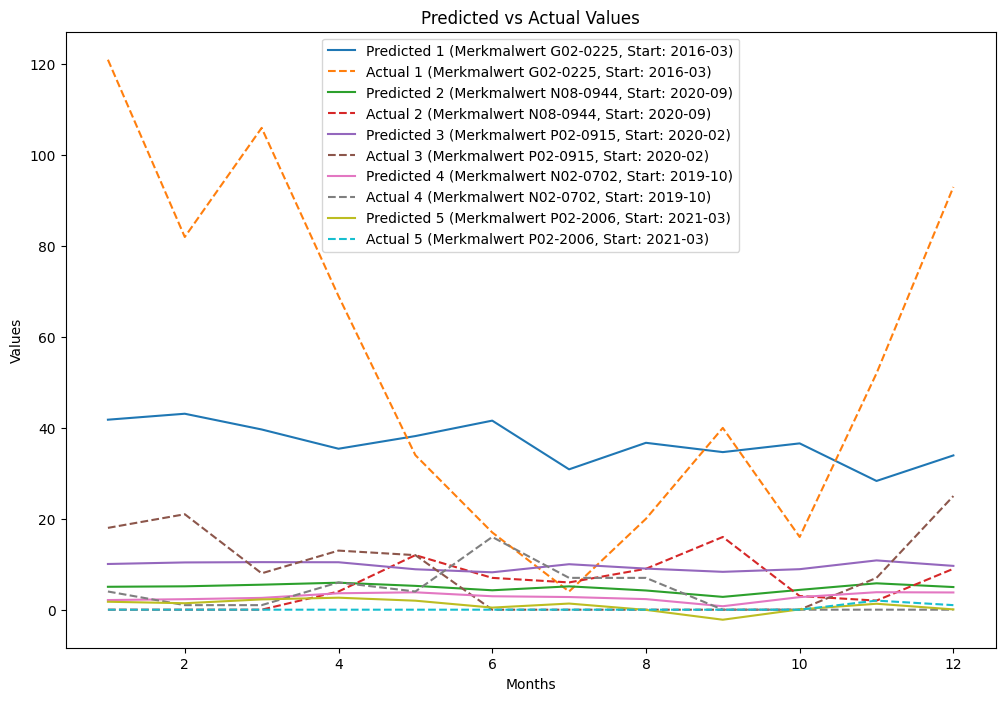

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Vergleich der Vorhersagen mit den tatsächlichen Werten
for i in range(min(len(predictions_rescaled), 5)):  # Zeige die ersten 5 Vorhersagen
    print(f"Prediction {i + 1}:")
    print(predictions_rescaled[i])
    print(f"Actual {i + 1}:")
    print(y_test_rescaled[i])

# Ergebnisse in einer Tabelle anzeigen
results = pd.DataFrame(predictions_rescaled[:5], columns=[f'Predicted_{i+1}' for i in range(12)])
actuals = pd.DataFrame(y_test_rescaled[:5], columns=[f'Actual_{i+1}' for i in range(12)])
results_combined = pd.concat([results, actuals], axis=1)
print(results_combined)

# Grafische Darstellung
plt.figure(figsize=(12, 8))
for i in range(5):  # Zeige die ersten 2 Vorhersagen
    start_date = pd.Timestamp(start_dates_test[i])  # Konvertiere numpy.datetime64 zu pandas.Timestamp
    plt.plot(range(1, 13), predictions_rescaled[i], label=f'Predicted {i+1} (Merkmalwert {merkmalwerte_test[i]}, Start: {start_date.strftime("%Y-%m")})')
    plt.plot(range(1, 13), y_test_rescaled[i], label=f'Actual {i+1} (Merkmalwert {merkmalwerte_test[i]}, Start: {start_date.strftime("%Y-%m")})', linestyle='dashed')
plt.xlabel('Months')
plt.ylabel('Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()